In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target+Count Encoding: Vary blending width
No blending of hierarchy, just check encoding NAICS using the target+counts.  Only encode NAICS (no higher level codes) as a baseline.  Vary lambda_f, which controls the width of the blending window

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

## Function to get metrics

In [10]:
def get_metrics(data, lambda_f= 20, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetCountEncoder(lambda_k = setup.selected_lambda_k, lambda_f = lambda_f) 
                for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [11]:
count_sets = [1, 5, 10, 20, 50, 100, 200, 500]

In [12]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, ['NAICS'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [13]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.688910,0.414320,0.314887,0.605533,0.345489,0.727882,1.0,1
1,test,0.694475,0.416557,0.318962,0.600203,0.346085,0.728209,1.0,5
1,test,0.635984,0.420261,0.295711,0.726081,0.347443,0.728884,1.0,10
1,test,0.640764,0.420426,0.297404,0.717029,0.345941,0.728822,1.0,20
1,test,0.654630,0.422427,0.303420,0.695034,0.346568,0.728364,1.0,50
1,test,0.662685,0.419636,0.305256,0.671094,0.346843,0.728618,1.0,100
1,test,0.645822,0.418769,0.298357,0.702140,0.346741,0.728546,1.0,200
1,test,0.667820,0.418065,0.306653,0.656628,0.348737,0.729107,1.0,500


In [14]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.658916,0.449522,0.336453,0.677054,0.382681,0.728241,0.0,1
0,test,0.660714,0.449361,0.337270,0.673048,0.383273,0.728552,0.0,5
0,test,0.660906,0.449463,0.337411,0.672944,0.384374,0.728620,0.0,10
0,test,0.659847,0.450388,0.337295,0.677574,0.383074,0.728524,0.0,20
0,test,0.659815,0.448706,0.336533,0.673048,0.382598,0.728385,0.0,50
0,test,0.660446,0.449567,0.337228,0.674140,0.384541,0.728515,0.0,100
0,test,0.660189,0.449189,0.336933,0.673620,0.383656,0.728480,0.0,200
0,test,0.662683,0.451337,0.339131,0.674504,0.383893,0.728784,0.0,500


In [15]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A03_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A03_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

#### Regular randomized test

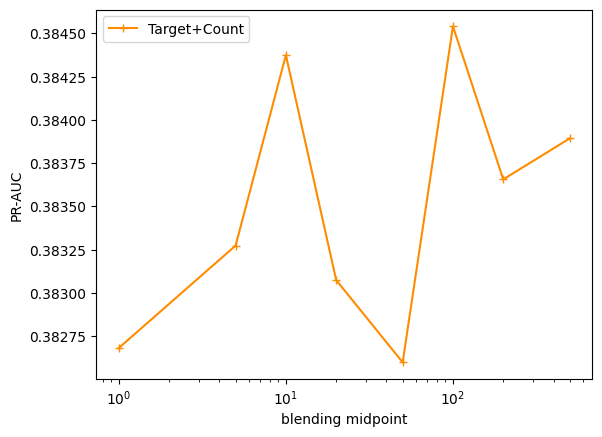

In [18]:
fig, ax = plt.subplots()
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending width')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

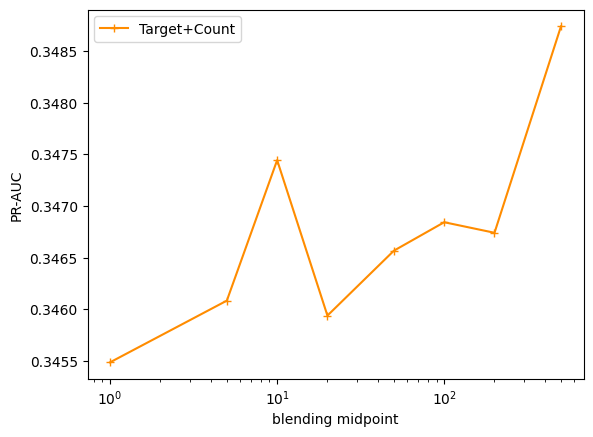

In [19]:
fig, ax = plt.subplots()
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending width')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

The width doesn't seem extremely important.  Ignore and keep at default throughout